In [5]:
# === IMPORTAÇÕES ===
import pandas as pd
import numpy as np
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

In [6]:
# === 1. Carregar base ===
df = pd.read_excel("../Data/base_vendas_pdv_IA.xlsx", sheet_name="Sheet1")

# Ordena e cria colunas temporais
df = df.sort_values(["PDV_ID", "Data"])
df["Ano"] = df["Data"].dt.year
df["Mes"] = df["Data"].dt.month


In [7]:
# === 2. Features e Target ===
features = ["Vendas", "Custo", "Lucro", "Satisfacao", "Mes", "Ano"]
target = "Meta"

X = df[features]
y = df[target]
    # === 3. Tratar valores ausentes ===
# Preenche valores nulos com a mediana (mais robusto)
df[features + [target]] = df[features + [target]].fillna(df[features + [target]].median(numeric_only=True))

# Atualiza X e y após limpeza
X = df[features]
y = df[target]

# === 4. Divisão Treino/Teste ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# === 5. Função objetivo do Optuna ===
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 2.0),
        "random_state": 42,
        "tree_method": "hist",
        "n_jobs": -1
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

# === 6. Rodar o Optuna ===
study = optuna.create_study(direction="minimize")
print("🚀 Rodando Optuna para XGBoost (pode levar alguns minutos)...")
study.optimize(objective, n_trials=60, show_progress_bar=True)

# === 7. Resultado dos melhores parâmetros ===
best_params = study.best_params
print("\nMelhores parâmetros encontrados:")
for k, v in best_params.items():
    print(f"{k}: {v}")


[I 2025-11-16 18:10:06,926] A new study created in memory with name: no-name-c8f90426-0d09-4bf9-b030-18d30c9a23d0


🚀 Rodando Optuna para XGBoost (pode levar alguns minutos)...


Best trial: 0. Best value: 129.917:   2%|▏         | 1/60 [00:00<00:15,  3.90it/s]

[I 2025-11-16 18:10:07,179] Trial 0 finished with value: 129.91674228069445 and parameters: {'n_estimators': 386, 'learning_rate': 0.10940415896209964, 'max_depth': 3, 'subsample': 0.9626052758497103, 'colsample_bytree': 0.6968706725027918, 'gamma': 3.078518806118544, 'reg_alpha': 0.9227835294021547, 'reg_lambda': 0.271526855436522}. Best is trial 0 with value: 129.91674228069445.


Best trial: 0. Best value: 129.917:   3%|▎         | 2/60 [00:02<01:13,  1.27s/it]

[I 2025-11-16 18:10:09,155] Trial 1 finished with value: 159.19920468717618 and parameters: {'n_estimators': 977, 'learning_rate': 0.09228833184523422, 'max_depth': 9, 'subsample': 0.7451981084415983, 'colsample_bytree': 0.6543117674295358, 'gamma': 3.5177791700415733, 'reg_alpha': 1.9800153472851902, 'reg_lambda': 1.7181803586330362}. Best is trial 0 with value: 129.91674228069445.


Best trial: 0. Best value: 129.917:   5%|▌         | 3/60 [00:02<00:53,  1.07it/s]

[I 2025-11-16 18:10:09,686] Trial 2 finished with value: 131.43441116951453 and parameters: {'n_estimators': 895, 'learning_rate': 0.01526154142888125, 'max_depth': 3, 'subsample': 0.7670668863494428, 'colsample_bytree': 0.501520242083465, 'gamma': 2.8902392972726036, 'reg_alpha': 1.1995215597469733, 'reg_lambda': 0.2569450519257781}. Best is trial 0 with value: 129.91674228069445.


Best trial: 0. Best value: 129.917:   7%|▋         | 4/60 [00:04<01:00,  1.08s/it]

[I 2025-11-16 18:10:10,990] Trial 3 finished with value: 150.07921035890288 and parameters: {'n_estimators': 517, 'learning_rate': 0.01803929842962433, 'max_depth': 9, 'subsample': 0.9482360702715816, 'colsample_bytree': 0.6546860923005142, 'gamma': 0.9698890867346427, 'reg_alpha': 0.5701037328987353, 'reg_lambda': 0.16550814875681352}. Best is trial 0 with value: 129.91674228069445.


Best trial: 0. Best value: 129.917:   8%|▊         | 5/60 [00:05<01:02,  1.14s/it]

[I 2025-11-16 18:10:12,246] Trial 4 finished with value: 132.82581970439733 and parameters: {'n_estimators': 915, 'learning_rate': 0.01773593089359195, 'max_depth': 7, 'subsample': 0.5365699836059452, 'colsample_bytree': 0.7557314878391318, 'gamma': 2.3736002013746393, 'reg_alpha': 0.5533664310688009, 'reg_lambda': 0.6239880182934394}. Best is trial 0 with value: 129.91674228069445.


Best trial: 0. Best value: 129.917:  10%|█         | 6/60 [00:06<00:54,  1.01s/it]

[I 2025-11-16 18:10:13,009] Trial 5 finished with value: 132.69513264554163 and parameters: {'n_estimators': 915, 'learning_rate': 0.04081125310481971, 'max_depth': 5, 'subsample': 0.9923771375413408, 'colsample_bytree': 0.6094534285252702, 'gamma': 3.4943775315880776, 'reg_alpha': 1.0383777149657771, 'reg_lambda': 1.0090398415251618}. Best is trial 0 with value: 129.91674228069445.


Best trial: 6. Best value: 127.607:  12%|█▏        | 7/60 [00:06<00:48,  1.10it/s]

[I 2025-11-16 18:10:13,701] Trial 6 finished with value: 127.60663951314366 and parameters: {'n_estimators': 990, 'learning_rate': 0.017924219088369477, 'max_depth': 4, 'subsample': 0.5133874317581492, 'colsample_bytree': 0.7864628531094056, 'gamma': 3.245638504698011, 'reg_alpha': 1.2115916615491604, 'reg_lambda': 1.5547513131782906}. Best is trial 6 with value: 127.60663951314366.


Best trial: 6. Best value: 127.607:  13%|█▎        | 8/60 [00:07<00:40,  1.27it/s]

[I 2025-11-16 18:10:14,226] Trial 7 finished with value: 133.39184280114392 and parameters: {'n_estimators': 692, 'learning_rate': 0.08104039864555, 'max_depth': 4, 'subsample': 0.8406289540001115, 'colsample_bytree': 0.5287759685798026, 'gamma': 3.8782232864887813, 'reg_alpha': 1.438888078300464, 'reg_lambda': 0.4583168951811305}. Best is trial 6 with value: 127.60663951314366.


Best trial: 6. Best value: 127.607:  15%|█▌        | 9/60 [00:07<00:35,  1.44it/s]

[I 2025-11-16 18:10:14,712] Trial 8 finished with value: 133.32208844943176 and parameters: {'n_estimators': 419, 'learning_rate': 0.05436228396447738, 'max_depth': 6, 'subsample': 0.5858161276086384, 'colsample_bytree': 0.9088000924440456, 'gamma': 1.9543391463223188, 'reg_alpha': 0.7226985161264816, 'reg_lambda': 0.9813431107829913}. Best is trial 6 with value: 127.60663951314366.


Best trial: 6. Best value: 127.607:  17%|█▋        | 10/60 [00:08<00:29,  1.68it/s]

[I 2025-11-16 18:10:15,091] Trial 9 finished with value: 131.07181018849022 and parameters: {'n_estimators': 354, 'learning_rate': 0.043297483771337214, 'max_depth': 6, 'subsample': 0.9211069434286587, 'colsample_bytree': 0.6907009972961407, 'gamma': 1.2588937456344302, 'reg_alpha': 0.3335989808957791, 'reg_lambda': 1.7781614662869027}. Best is trial 6 with value: 127.60663951314366.


Best trial: 6. Best value: 127.607:  20%|██        | 12/60 [00:09<00:26,  1.78it/s]

[I 2025-11-16 18:10:16,154] Trial 10 finished with value: 153.827921551878 and parameters: {'n_estimators': 697, 'learning_rate': 0.2222983768705518, 'max_depth': 7, 'subsample': 0.6474558783333083, 'colsample_bytree': 0.8463863914371752, 'gamma': 4.898417229755777, 'reg_alpha': 0.038414795333800655, 'reg_lambda': 1.4378231601514997}. Best is trial 6 with value: 127.60663951314366.
[I 2025-11-16 18:10:16,310] Trial 11 finished with value: 131.14757665331962 and parameters: {'n_estimators': 219, 'learning_rate': 0.21239442451274126, 'max_depth': 3, 'subsample': 0.6851103056409356, 'colsample_bytree': 0.7943761629194548, 'gamma': 4.4318923744332945, 'reg_alpha': 1.5198929772833052, 'reg_lambda': 1.3501552947670044}. Best is trial 6 with value: 127.60663951314366.


Best trial: 6. Best value: 127.607:  22%|██▏       | 13/60 [00:09<00:26,  1.79it/s]

[I 2025-11-16 18:10:16,860] Trial 12 finished with value: 136.73176310011456 and parameters: {'n_estimators': 732, 'learning_rate': 0.12678018238583075, 'max_depth': 4, 'subsample': 0.8556736792149233, 'colsample_bytree': 0.9883659323092895, 'gamma': 0.07731040360532182, 'reg_alpha': 0.9338408555818996, 'reg_lambda': 0.8640263238166342}. Best is trial 6 with value: 127.60663951314366.


Best trial: 13. Best value: 127.052:  23%|██▎       | 14/60 [00:10<00:23,  1.96it/s]

[I 2025-11-16 18:10:17,259] Trial 13 finished with value: 127.05152830771864 and parameters: {'n_estimators': 539, 'learning_rate': 0.033114519803980884, 'max_depth': 4, 'subsample': 0.5127343101655087, 'colsample_bytree': 0.8462877409928664, 'gamma': 3.043932157806632, 'reg_alpha': 1.5280723291424572, 'reg_lambda': 1.3353111544755927}. Best is trial 13 with value: 127.05152830771864.


Best trial: 13. Best value: 127.052:  25%|██▌       | 15/60 [00:10<00:23,  1.94it/s]

[I 2025-11-16 18:10:17,789] Trial 14 finished with value: 127.35074844663953 and parameters: {'n_estimators': 567, 'learning_rate': 0.02571521404603027, 'max_depth': 5, 'subsample': 0.5091799273189777, 'colsample_bytree': 0.8583346875702832, 'gamma': 2.181649716750402, 'reg_alpha': 1.82443992506002, 'reg_lambda': 1.402535698954117}. Best is trial 13 with value: 127.05152830771864.


Best trial: 13. Best value: 127.052:  27%|██▋       | 16/60 [00:11<00:22,  1.98it/s]

[I 2025-11-16 18:10:18,271] Trial 15 finished with value: 127.20661549488761 and parameters: {'n_estimators': 540, 'learning_rate': 0.028154195259622494, 'max_depth': 5, 'subsample': 0.6011331463252096, 'colsample_bytree': 0.8813206060092165, 'gamma': 1.931357067348852, 'reg_alpha': 1.916907720194491, 'reg_lambda': 1.970137302095693}. Best is trial 13 with value: 127.05152830771864.


Best trial: 16. Best value: 126.841:  28%|██▊       | 17/60 [00:11<00:21,  2.02it/s]

[I 2025-11-16 18:10:18,742] Trial 16 finished with value: 126.84050784848239 and parameters: {'n_estimators': 484, 'learning_rate': 0.02930267593127962, 'max_depth': 5, 'subsample': 0.6229084157657877, 'colsample_bytree': 0.9601639763349763, 'gamma': 1.4576735417558115, 'reg_alpha': 1.6587130832756298, 'reg_lambda': 1.9569875867363329}. Best is trial 16 with value: 126.84050784848239.


Best trial: 16. Best value: 126.841:  30%|███       | 18/60 [00:12<00:21,  1.98it/s]

[I 2025-11-16 18:10:19,268] Trial 17 finished with value: 140.6092606227259 and parameters: {'n_estimators': 265, 'learning_rate': 0.01034229090705184, 'max_depth': 8, 'subsample': 0.5864273738536305, 'colsample_bytree': 0.996138388532294, 'gamma': 1.196180775032514, 'reg_alpha': 1.6315674765601609, 'reg_lambda': 1.2077083109220217}. Best is trial 16 with value: 126.84050784848239.


Best trial: 16. Best value: 126.841:  32%|███▏      | 19/60 [00:12<00:19,  2.06it/s]

[I 2025-11-16 18:10:19,711] Trial 18 finished with value: 126.87561658731346 and parameters: {'n_estimators': 479, 'learning_rate': 0.02717145896069396, 'max_depth': 5, 'subsample': 0.6714802457816372, 'colsample_bytree': 0.9363538627724365, 'gamma': 0.2983090048306476, 'reg_alpha': 1.3064756244418219, 'reg_lambda': 1.9749528664134903}. Best is trial 16 with value: 126.84050784848239.


Best trial: 16. Best value: 126.841:  33%|███▎      | 20/60 [00:14<00:29,  1.37it/s]

[I 2025-11-16 18:10:21,011] Trial 19 finished with value: 147.9754167752136 and parameters: {'n_estimators': 445, 'learning_rate': 0.06553413348308768, 'max_depth': 10, 'subsample': 0.6789101282960135, 'colsample_bytree': 0.9335097657680439, 'gamma': 0.035865840614012046, 'reg_alpha': 1.3105281487170155, 'reg_lambda': 1.87447099605372}. Best is trial 16 with value: 126.84050784848239.


Best trial: 16. Best value: 126.841:  35%|███▌      | 21/60 [00:14<00:24,  1.60it/s]

[I 2025-11-16 18:10:21,389] Trial 20 finished with value: 130.93232543135707 and parameters: {'n_estimators': 317, 'learning_rate': 0.011031959343753776, 'max_depth': 6, 'subsample': 0.7610028387640159, 'colsample_bytree': 0.9393922047913942, 'gamma': 0.7593054535265711, 'reg_alpha': 1.671657868425449, 'reg_lambda': 1.6473803748150664}. Best is trial 16 with value: 126.84050784848239.


Best trial: 16. Best value: 126.841:  37%|███▋      | 22/60 [00:15<00:23,  1.60it/s]

[I 2025-11-16 18:10:22,015] Trial 21 finished with value: 127.38659505868011 and parameters: {'n_estimators': 629, 'learning_rate': 0.03042666327598682, 'max_depth': 5, 'subsample': 0.6300047021906904, 'colsample_bytree': 0.9562841627727666, 'gamma': 1.5102222742340552, 'reg_alpha': 1.7268190493401874, 'reg_lambda': 1.9982592377709274}. Best is trial 16 with value: 126.84050784848239.


Best trial: 16. Best value: 126.841:  38%|███▊      | 23/60 [00:15<00:20,  1.77it/s]

[I 2025-11-16 18:10:22,445] Trial 22 finished with value: 127.1655222936193 and parameters: {'n_estimators': 508, 'learning_rate': 0.034757229063447845, 'max_depth': 4, 'subsample': 0.5611049355775519, 'colsample_bytree': 0.8336932294218079, 'gamma': 0.3572772316717753, 'reg_alpha': 1.4259143637858902, 'reg_lambda': 1.203744817478119}. Best is trial 16 with value: 126.84050784848239.


Best trial: 16. Best value: 126.841:  40%|████      | 24/60 [00:16<00:19,  1.82it/s]

[I 2025-11-16 18:10:22,960] Trial 23 finished with value: 126.96869089709895 and parameters: {'n_estimators': 489, 'learning_rate': 0.025411282510461528, 'max_depth': 5, 'subsample': 0.7074523070667078, 'colsample_bytree': 0.9010416847955667, 'gamma': 2.6494381684305357, 'reg_alpha': 1.5136869752525404, 'reg_lambda': 1.7960960960906325}. Best is trial 16 with value: 126.84050784848239.


Best trial: 16. Best value: 126.841:  42%|████▏     | 25/60 [00:16<00:19,  1.84it/s]

[I 2025-11-16 18:10:23,486] Trial 24 finished with value: 127.60294905143182 and parameters: {'n_estimators': 471, 'learning_rate': 0.02290228406576973, 'max_depth': 6, 'subsample': 0.7152821164578937, 'colsample_bytree': 0.9185420841998251, 'gamma': 0.5772374955988184, 'reg_alpha': 1.2601660789050746, 'reg_lambda': 1.8470497946580613}. Best is trial 16 with value: 126.84050784848239.


Best trial: 16. Best value: 126.841:  43%|████▎     | 26/60 [00:17<00:18,  1.83it/s]

[I 2025-11-16 18:10:24,042] Trial 25 finished with value: 129.839424126779 and parameters: {'n_estimators': 620, 'learning_rate': 0.04557263248721033, 'max_depth': 5, 'subsample': 0.8075400999282986, 'colsample_bytree': 0.9633635507486155, 'gamma': 1.5567417272429092, 'reg_alpha': 1.0921334466343637, 'reg_lambda': 1.5946548587320484}. Best is trial 16 with value: 126.84050784848239.


Best trial: 26. Best value: 126.834:  45%|████▌     | 27/60 [00:17<00:15,  2.09it/s]

[I 2025-11-16 18:10:24,362] Trial 26 finished with value: 126.83388583178369 and parameters: {'n_estimators': 324, 'learning_rate': 0.021294846526490926, 'max_depth': 5, 'subsample': 0.652111886588592, 'colsample_bytree': 0.8887417823184109, 'gamma': 1.8221814046669746, 'reg_alpha': 1.7969486009632463, 'reg_lambda': 1.7914414097660456}. Best is trial 26 with value: 126.83388583178369.


Best trial: 26. Best value: 126.834:  47%|████▋     | 28/60 [00:17<00:15,  2.11it/s]

[I 2025-11-16 18:10:24,822] Trial 27 finished with value: 135.84475262995406 and parameters: {'n_estimators': 304, 'learning_rate': 0.013501595704582791, 'max_depth': 7, 'subsample': 0.6512159096348533, 'colsample_bytree': 0.8000086875774736, 'gamma': 1.6712586426845335, 'reg_alpha': 1.74722088865908, 'reg_lambda': 1.9879900714884275}. Best is trial 26 with value: 126.83388583178369.


Best trial: 26. Best value: 126.834:  48%|████▊     | 29/60 [00:18<00:14,  2.11it/s]

[I 2025-11-16 18:10:25,298] Trial 28 finished with value: 127.05622092801505 and parameters: {'n_estimators': 390, 'learning_rate': 0.020654289732660064, 'max_depth': 6, 'subsample': 0.6134733661958182, 'colsample_bytree': 0.8758949554502398, 'gamma': 0.9487571467973014, 'reg_alpha': 1.8660106539348524, 'reg_lambda': 1.5362553942139483}. Best is trial 26 with value: 126.83388583178369.


Best trial: 26. Best value: 126.834:  50%|█████     | 30/60 [00:18<00:12,  2.41it/s]

[I 2025-11-16 18:10:25,574] Trial 29 finished with value: 132.59212129597114 and parameters: {'n_estimators': 373, 'learning_rate': 0.013237926763871168, 'max_depth': 3, 'subsample': 0.6702397390294759, 'colsample_bytree': 0.9738886958902866, 'gamma': 0.4669023181760823, 'reg_alpha': 1.3730896088160087, 'reg_lambda': 1.6916735138006107}. Best is trial 26 with value: 126.83388583178369.


Best trial: 26. Best value: 126.834:  52%|█████▏    | 31/60 [00:19<00:12,  2.29it/s]

[I 2025-11-16 18:10:26,061] Trial 30 finished with value: 142.10319389371372 and parameters: {'n_estimators': 231, 'learning_rate': 0.05903633178374726, 'max_depth': 8, 'subsample': 0.7239224072115098, 'colsample_bytree': 0.7380825184227007, 'gamma': 1.2823267267067402, 'reg_alpha': 0.818877053077727, 'reg_lambda': 0.008987239232323363}. Best is trial 26 with value: 126.83388583178369.


Best trial: 26. Best value: 126.834:  53%|█████▎    | 32/60 [00:19<00:12,  2.30it/s]

[I 2025-11-16 18:10:26,490] Trial 31 finished with value: 127.0932675604936 and parameters: {'n_estimators': 465, 'learning_rate': 0.024150721381501466, 'max_depth': 5, 'subsample': 0.702979445055984, 'colsample_bytree': 0.9169001803051404, 'gamma': 2.60365759304905, 'reg_alpha': 1.5891973560280956, 'reg_lambda': 1.8437639899264102}. Best is trial 26 with value: 126.83388583178369.


Best trial: 26. Best value: 126.834:  55%|█████▌    | 33/60 [00:19<00:10,  2.52it/s]

[I 2025-11-16 18:10:26,800] Trial 32 finished with value: 127.31693119912087 and parameters: {'n_estimators': 322, 'learning_rate': 0.039214171970699416, 'max_depth': 5, 'subsample': 0.6400797079317144, 'colsample_bytree': 0.8920162325049145, 'gamma': 2.7209570964772896, 'reg_alpha': 1.9541928504771955, 'reg_lambda': 1.7761727077837923}. Best is trial 26 with value: 126.83388583178369.


Best trial: 33. Best value: 126.519:  57%|█████▋    | 34/60 [00:20<00:09,  2.62it/s]

[I 2025-11-16 18:10:27,145] Trial 33 finished with value: 126.51861234930568 and parameters: {'n_estimators': 408, 'learning_rate': 0.022325953138166786, 'max_depth': 4, 'subsample': 0.7347974048434365, 'colsample_bytree': 0.9493752490710751, 'gamma': 2.1648541159985535, 'reg_alpha': 1.8133073067473853, 'reg_lambda': 1.903843846179597}. Best is trial 33 with value: 126.51861234930568.


Best trial: 33. Best value: 126.519:  58%|█████▊    | 35/60 [00:20<00:08,  2.84it/s]

[I 2025-11-16 18:10:27,427] Trial 34 finished with value: 128.17317955832317 and parameters: {'n_estimators': 415, 'learning_rate': 0.020426072390090044, 'max_depth': 3, 'subsample': 0.7911018059702783, 'colsample_bytree': 0.9484903168650173, 'gamma': 2.0424222870331565, 'reg_alpha': 1.7819750460572283, 'reg_lambda': 1.901990476401045}. Best is trial 33 with value: 126.51861234930568.


Best trial: 35. Best value: 126.245:  60%|██████    | 36/60 [00:20<00:09,  2.59it/s]

[I 2025-11-16 18:10:27,893] Trial 35 finished with value: 126.24505226804301 and parameters: {'n_estimators': 577, 'learning_rate': 0.016118185396753387, 'max_depth': 4, 'subsample': 0.7418131699201103, 'colsample_bytree': 0.9967033334068591, 'gamma': 2.447404119221687, 'reg_alpha': 1.9862595788323008, 'reg_lambda': 1.6142612796301923}. Best is trial 35 with value: 126.24505226804301.


Best trial: 35. Best value: 126.245:  62%|██████▏   | 37/60 [00:21<00:09,  2.45it/s]

[I 2025-11-16 18:10:28,352] Trial 36 finished with value: 126.38012013445903 and parameters: {'n_estimators': 579, 'learning_rate': 0.015315493279450594, 'max_depth': 4, 'subsample': 0.7482632639626756, 'colsample_bytree': 0.9888336691741009, 'gamma': 2.304261162715366, 'reg_alpha': 1.9872377638594099, 'reg_lambda': 1.6879225856420037}. Best is trial 35 with value: 126.24505226804301.


Best trial: 37. Best value: 126.043:  63%|██████▎   | 38/60 [00:22<00:10,  2.15it/s]

[I 2025-11-16 18:10:28,952] Trial 37 finished with value: 126.04333265446529 and parameters: {'n_estimators': 795, 'learning_rate': 0.01556496177413199, 'max_depth': 4, 'subsample': 0.7501664892278881, 'colsample_bytree': 0.999147671203772, 'gamma': 2.3252485351139374, 'reg_alpha': 1.998891902453665, 'reg_lambda': 1.5073295830276452}. Best is trial 37 with value: 126.04333265446529.


Best trial: 37. Best value: 126.043:  65%|██████▌   | 39/60 [00:22<00:10,  2.06it/s]

[I 2025-11-16 18:10:29,484] Trial 38 finished with value: 126.60288355085898 and parameters: {'n_estimators': 785, 'learning_rate': 0.015016650264606482, 'max_depth': 3, 'subsample': 0.7382427174438771, 'colsample_bytree': 0.9956770314649449, 'gamma': 2.3442706333155563, 'reg_alpha': 1.9956762015743992, 'reg_lambda': 1.4813910064220364}. Best is trial 37 with value: 126.04333265446529.


Best trial: 37. Best value: 126.043:  67%|██████▋   | 40/60 [00:23<00:10,  1.87it/s]

[I 2025-11-16 18:10:30,139] Trial 39 finished with value: 126.14389495512273 and parameters: {'n_estimators': 834, 'learning_rate': 0.015931879041236743, 'max_depth': 4, 'subsample': 0.7854204620583647, 'colsample_bytree': 0.975644981626518, 'gamma': 3.362262228426489, 'reg_alpha': 1.910568833606109, 'reg_lambda': 1.6695147530734584}. Best is trial 37 with value: 126.04333265446529.


Best trial: 40. Best value: 125.93:  68%|██████▊   | 41/60 [00:23<00:10,  1.75it/s] 

[I 2025-11-16 18:10:30,790] Trial 40 finished with value: 125.92965489094452 and parameters: {'n_estimators': 843, 'learning_rate': 0.01532169399097939, 'max_depth': 4, 'subsample': 0.8621141496762458, 'colsample_bytree': 0.9984448819872853, 'gamma': 3.4317914133243295, 'reg_alpha': 1.9983932185718813, 'reg_lambda': 1.2098099344474105}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  70%|███████   | 42/60 [00:24<00:10,  1.69it/s]

[I 2025-11-16 18:10:31,426] Trial 41 finished with value: 126.10367070017445 and parameters: {'n_estimators': 845, 'learning_rate': 0.015885098454707598, 'max_depth': 4, 'subsample': 0.8734542891042292, 'colsample_bytree': 0.9993131441897146, 'gamma': 3.6953878845369754, 'reg_alpha': 1.9860621476638793, 'reg_lambda': 1.231575933662543}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  72%|███████▏  | 43/60 [00:25<00:10,  1.65it/s]

[I 2025-11-16 18:10:32,068] Trial 42 finished with value: 126.11856299223932 and parameters: {'n_estimators': 841, 'learning_rate': 0.012390050029275946, 'max_depth': 4, 'subsample': 0.8906728158356119, 'colsample_bytree': 0.9985386558776447, 'gamma': 3.7381209637314337, 'reg_alpha': 1.8890701148509133, 'reg_lambda': 1.170313125777146}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  73%|███████▎  | 44/60 [00:25<00:09,  1.64it/s]

[I 2025-11-16 18:10:32,687] Trial 43 finished with value: 134.8359368559149 and parameters: {'n_estimators': 852, 'learning_rate': 0.0120925616059915, 'max_depth': 3, 'subsample': 0.9063057285377086, 'colsample_bytree': 0.6146514513196263, 'gamma': 3.749699588669033, 'reg_alpha': 1.882947662291301, 'reg_lambda': 1.1203816769553716}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  75%|███████▌  | 45/60 [00:26<00:09,  1.64it/s]

[I 2025-11-16 18:10:33,299] Trial 44 finished with value: 126.40718821604986 and parameters: {'n_estimators': 867, 'learning_rate': 0.017514788554769567, 'max_depth': 3, 'subsample': 0.8505925702702485, 'colsample_bytree': 0.9715317241290256, 'gamma': 3.3220390814221314, 'reg_alpha': 1.879983163999737, 'reg_lambda': 0.737901290349935}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  77%|███████▋  | 46/60 [00:27<00:09,  1.54it/s]

[I 2025-11-16 18:10:34,046] Trial 45 finished with value: 126.02109274429176 and parameters: {'n_estimators': 951, 'learning_rate': 0.012540783687424782, 'max_depth': 4, 'subsample': 0.8823608802367853, 'colsample_bytree': 0.9721521482996172, 'gamma': 4.197310423349997, 'reg_alpha': 1.710481336275231, 'reg_lambda': 1.0508405428541927}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  78%|███████▊  | 47/60 [00:27<00:08,  1.46it/s]

[I 2025-11-16 18:10:34,812] Trial 46 finished with value: 126.01474268801528 and parameters: {'n_estimators': 955, 'learning_rate': 0.011693471806558029, 'max_depth': 4, 'subsample': 0.8873156913297363, 'colsample_bytree': 0.9251928348012285, 'gamma': 4.184466183747587, 'reg_alpha': 1.723213744610848, 'reg_lambda': 1.0167004366715429}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  80%|████████  | 48/60 [00:28<00:08,  1.39it/s]

[I 2025-11-16 18:10:35,608] Trial 47 finished with value: 126.12013181614716 and parameters: {'n_estimators': 952, 'learning_rate': 0.010066640885295953, 'max_depth': 4, 'subsample': 0.9441641810200356, 'colsample_bytree': 0.9712828497765977, 'gamma': 4.269249175747412, 'reg_alpha': 1.7288007792044737, 'reg_lambda': 1.0389741680569708}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  82%|████████▏ | 49/60 [00:29<00:07,  1.42it/s]

[I 2025-11-16 18:10:36,286] Trial 48 finished with value: 134.21811130509624 and parameters: {'n_estimators': 947, 'learning_rate': 0.14211113066887704, 'max_depth': 3, 'subsample': 0.8855046060470319, 'colsample_bytree': 0.9253702465329796, 'gamma': 4.138423337257969, 'reg_alpha': 0.34061036111593834, 'reg_lambda': 0.8756858514992587}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  83%|████████▎ | 50/60 [00:29<00:06,  1.47it/s]

[I 2025-11-16 18:10:36,906] Trial 49 finished with value: 130.63078742278174 and parameters: {'n_estimators': 801, 'learning_rate': 0.019043958822043155, 'max_depth': 4, 'subsample': 0.9997303523316766, 'colsample_bytree': 0.5634287618194777, 'gamma': 4.7132544316122456, 'reg_alpha': 1.6199255998072195, 'reg_lambda': 1.2894212470838848}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  85%|████████▌ | 51/60 [00:30<00:06,  1.48it/s]

[I 2025-11-16 18:10:37,573] Trial 50 finished with value: 128.20766924684503 and parameters: {'n_estimators': 1000, 'learning_rate': 0.013748711880945013, 'max_depth': 3, 'subsample': 0.8287497737648009, 'colsample_bytree': 0.7154796261026721, 'gamma': 4.001309067631653, 'reg_alpha': 1.5479285283863289, 'reg_lambda': 0.9140202077983772}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  87%|████████▋ | 52/60 [00:31<00:05,  1.44it/s]

[I 2025-11-16 18:10:38,306] Trial 51 finished with value: 125.95554211272857 and parameters: {'n_estimators': 901, 'learning_rate': 0.011826376171661643, 'max_depth': 4, 'subsample': 0.8771269121223527, 'colsample_bytree': 0.9752866724803231, 'gamma': 3.651940563291044, 'reg_alpha': 1.8731837252899168, 'reg_lambda': 1.0890571097214856}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  88%|████████▊ | 53/60 [00:32<00:04,  1.41it/s]

[I 2025-11-16 18:10:39,050] Trial 52 finished with value: 126.55207596173773 and parameters: {'n_estimators': 907, 'learning_rate': 0.01192901139624456, 'max_depth': 4, 'subsample': 0.9642628688068325, 'colsample_bytree': 0.9783918001660752, 'gamma': 4.50560995675319, 'reg_alpha': 1.6863270899508076, 'reg_lambda': 1.0673397092517547}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  90%|█████████ | 54/60 [00:32<00:04,  1.40it/s]

[I 2025-11-16 18:10:39,781] Trial 53 finished with value: 126.27497324348285 and parameters: {'n_estimators': 881, 'learning_rate': 0.010017216494988853, 'max_depth': 4, 'subsample': 0.8641663842071782, 'colsample_bytree': 0.9496702940311847, 'gamma': 3.082350882412398, 'reg_alpha': 1.8176013049736808, 'reg_lambda': 0.7771622819317456}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  92%|█████████▏| 55/60 [00:33<00:03,  1.36it/s]

[I 2025-11-16 18:10:40,572] Trial 54 finished with value: 126.49254103613497 and parameters: {'n_estimators': 942, 'learning_rate': 0.01787039860543248, 'max_depth': 4, 'subsample': 0.9264041323130151, 'colsample_bytree': 0.9309009494522527, 'gamma': 3.632983085863384, 'reg_alpha': 1.9954596801737607, 'reg_lambda': 0.9576509411692427}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  93%|█████████▎| 56/60 [00:34<00:02,  1.49it/s]

[I 2025-11-16 18:10:41,080] Trial 55 finished with value: 127.6521963624666 and parameters: {'n_estimators': 763, 'learning_rate': 0.0117360581530816, 'max_depth': 3, 'subsample': 0.8257306525098214, 'colsample_bytree': 0.9600067269742593, 'gamma': 3.9528217553825233, 'reg_alpha': 1.912215576047561, 'reg_lambda': 1.2841674914441081}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  95%|█████████▌| 57/60 [00:34<00:02,  1.46it/s]

[I 2025-11-16 18:10:41,808] Trial 56 finished with value: 126.21093465738993 and parameters: {'n_estimators': 968, 'learning_rate': 0.01430934087754067, 'max_depth': 4, 'subsample': 0.8772226300731049, 'colsample_bytree': 0.9112496952866942, 'gamma': 3.4813902176975366, 'reg_alpha': 1.7129562261564186, 'reg_lambda': 0.5644646959730589}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  97%|█████████▋| 58/60 [00:35<00:01,  1.40it/s]

[I 2025-11-16 18:10:42,592] Trial 57 finished with value: 127.44419990601395 and parameters: {'n_estimators': 910, 'learning_rate': 0.016942348838253796, 'max_depth': 5, 'subsample': 0.9084227949470132, 'colsample_bytree': 0.9834130369363113, 'gamma': 4.428562586646507, 'reg_alpha': 1.4663916626514193, 'reg_lambda': 1.1285521052456355}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93:  98%|█████████▊| 59/60 [00:36<00:00,  1.57it/s]

[I 2025-11-16 18:10:43,045] Trial 58 finished with value: 128.21049132356242 and parameters: {'n_estimators': 704, 'learning_rate': 0.011617158696271696, 'max_depth': 3, 'subsample': 0.9534980757687908, 'colsample_bytree': 0.8662299323724956, 'gamma': 4.977526622929248, 'reg_alpha': 1.8389364720723385, 'reg_lambda': 1.347251185660319}. Best is trial 40 with value: 125.92965489094452.


Best trial: 40. Best value: 125.93: 100%|██████████| 60/60 [00:37<00:00,  1.62it/s]

[I 2025-11-16 18:10:43,972] Trial 59 finished with value: 140.161543686599 and parameters: {'n_estimators': 817, 'learning_rate': 0.08437497435161248, 'max_depth': 6, 'subsample': 0.974952082268019, 'colsample_bytree': 0.8190808767819153, 'gamma': 3.0130524077737206, 'reg_alpha': 1.776372779477355, 'reg_lambda': 1.2502706307887674}. Best is trial 40 with value: 125.92965489094452.

Melhores parâmetros encontrados:
n_estimators: 843
learning_rate: 0.01532169399097939
max_depth: 4
subsample: 0.8621141496762458
colsample_bytree: 0.9984448819872853
gamma: 3.4317914133243295
reg_alpha: 1.9983932185718813
reg_lambda: 1.2098099344474105


In [9]:
# === 8. Treinar o modelo final ===
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# === 9. Avaliação ===
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nMÉTRICAS DO MELHOR MODELO")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")


MÉTRICAS DO MELHOR MODELO
MAE:  126.12
RMSE: 173.69
R²:   0.943


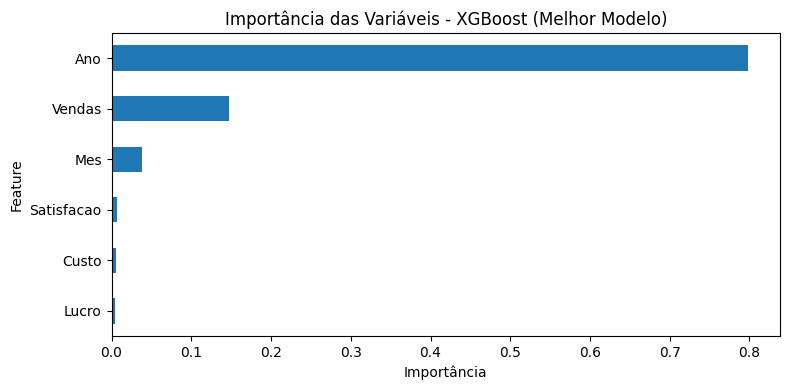

In [10]:
# === 10. Importância das variáveis ===
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)

plt.figure(figsize=(8, 4))
feat_imp.plot(kind="barh")
plt.title("Importância das Variáveis - XGBoost (Melhor Modelo)")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [11]:

# === 11. Salvar o modelo final ===
best_model.save_model("xgb_best_model.json")
joblib.dump(best_model, "xgb_best_model.pkl")

print("\n✅ Modelo salvo como 'xgb_best_model.json' e 'xgb_best_model.pkl'.")
print("Pronto para uso em previsões futuras!")



✅ Modelo salvo como 'xgb_best_model.json' e 'xgb_best_model.pkl'.
Pronto para uso em previsões futuras!


In [12]:
# === 12. Carregar modelo treinado ===
model = joblib.load("xgb_best_model.pkl") 

In [13]:
# === 13. Gerar previsões para os próximos 8 meses ===
predicoes_futuras = []

for pdv_id, grupo in df.groupby("PDV_ID"):
    ultimo_registro = grupo.sort_values("Data").iloc[-1].copy()
    base_pred = []

    mes = int(ultimo_registro["Mes"])
    ano = int(ultimo_registro["Ano"])

    for i in range(1, 9):  # próximos 8 meses
        mes += 1
        if mes > 12:
            mes = 1
            ano += 1

        nova_linha = ultimo_registro.copy()
        nova_linha["Mes"] = mes
        nova_linha["Ano"] = ano

        # aqui você pode manter os últimos valores de Vendas, Custo, etc.
        base_pred.append(nova_linha[features])

    # Cria DataFrame dos 8 próximos meses
    df_pred = pd.DataFrame(base_pred)

    # Prever metas
    df_pred["Meta_Prevista"] = model.predict(df_pred[features])

    # Adicionar PDV e datas projetadas
    df_pred["PDV_ID"] = pdv_id
    predicoes_futuras.append(df_pred)

# === 14. Concatenar todas as previsões ===
df_futuro = pd.concat(predicoes_futuras, ignore_index=True)


In [14]:
# === 15. Mostrar resultados ===
print(df_futuro[["PDV_ID", "Ano", "Mes", "Meta_Prevista"]])


    PDV_ID   Ano  Mes  Meta_Prevista
0    PDV_1  2025    9    2411.722412
1    PDV_1  2025   10    2508.013428
2    PDV_1  2025   11    2404.297119
3    PDV_1  2025   12    2558.754150
4    PDV_1  2026    1    2780.963379
..     ...   ...  ...            ...
419  PDV_9  2025   12    2529.355469
420  PDV_9  2026    1    2798.061279
421  PDV_9  2026    2    2763.304199
422  PDV_9  2026    3    2799.555176
423  PDV_9  2026    4    2804.218506

[424 rows x 4 columns]


In [15]:
# === 16. (Opcional) Salvar em Excel ===
df_futuro.to_excel("previsao_8_meses_por_pdv.xlsx", index=False)
print("\n✅ Previsões salvas em 'previsao_8_meses_por_pdv.xlsx'")


✅ Previsões salvas em 'previsao_8_meses_por_pdv.xlsx'
